# Lewinson Chapter 4 - Multi-Factor Models

## Introduction

Chapter 4 of Eryk Lewinson's [*Python for Finance Cookbook*](https://www.packtpub.com/product/python-for-finance-cookbook/9781789618518) discusses the capital asset pricing model (CAPM) and several multi-factor models.

We will focus on:

1. Refreshing our knowledge on the CAPM, particularly how to interpret $\alpha$s and $\beta$s
1. Implementing and interpreting multifactor models

***Note:*** Indented block quotes are from Lewinson, and section numbers differ from Lewinson because we will not discuss every topic.

I will simplify and streamline his code, where possible.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
%config InlineBackend.figure_format = 'retina'
%precision 4
pd.options.display.float_format = '{:.4f}'.format

In [3]:
import requests_cache
session = requests_cache.CachedSession(expire_after='1D')
import yfinance as yf
import pandas_datareader as pdr

## Implementing the CAPM in Python

Lewinson clearly summarizes the capital asset pricing model (CAPM):

> In this recipe, we learn how to estimate the famous Capital Asset Pricing Model (CAPM) and obtain the beta coefficient. This model represents the relationship between the expected return on a risky asset and the market risk (also known as systematic or undiversifiable risk). CAPM can be considered a one-factor model, on top of which more complex factor models were built.
> 
> CAPM is represented by the following equation: $$E(r_i) = r_f + \beta_i (E(r_m) - r_f)$$
> 
> Here, $E(r_i)$ denotes the expected return on asset $i$, $r_f$ is the risk-free rate (such as a government bond), $E(r_m)$ is the expected return on the market, and $\beta_i$ is the beta coefficient.
>
> Beta can be interpreted as the level of the asset return's sensitivity, as compared to the market in general. Some possible examples include:
> 
> - $\beta <= -1$: The asset moves in the opposite direction as the benchmark and in a greater amount than the negative of the benchmark.
> - $-1 < \beta < 0$: The asset moves in the opposite direction to the benchmark.
> - $\beta = 0$: There is no correlation between the asset's price movement and the market benchmark.
> - $0 < \beta < 1$: The asset moves in the same direction as the market, but the amount is smaller. An example might be the stock of a company that is not very susceptible to day-to-day fluctuations.
> - $\beta = 1$: The asset and the market are moving in the same direction by the same amount.
> - $\beta > 1$: The asset moves in the same direction as the market, but the amount is greater. An example might be the stock of a company that is very susceptible to day-to-day market news.
>
> CAPM can also be represented: $$E(r_i) - r_f = \beta_i (E(r_m) - r_F)$$
>
> Here, the left-hand side of the equation can be interpreted as the risk premium, while the right-hand side contains the market premium. The same equation can be reshaped into: $$\beta_i = \frac{cov(R_i, R_m)}{var(R_m)}$$
>
> Here, $R_i = E(r_i) - r_f$ and $R_m = E(r_m) - r_f$.

We will follow Lewinson's layout, but change his syntax to match the syntax we use elsewhere in the course.
To move beyond the CAPM, we need the statsmodels package for linear regressions and rolling linear regressions.
We will use statsmodels' formula API (advanced programming interface) to match R's regression formulas.

In [4]:
import statsmodels.formula.api as smf

We will also estimate the CAPM for Amazon (AMZN), but we will not limit our data download.

In [5]:
amzn = yf.download(tickers='AMZN', session=session)
amzn.index = amzn.index.tz_localize(None)

[*********************100%***********************]  1 of 1 completed

Lewinson uses the S&P 500 index from Yahoo! Finance (ticker `^GSPC`) as his market return.
`^GSPC` is not a total return index, so it excludes dividends and is incorrect for CAPM estimations.
Instead, we will use Ken French's `Mkt-RF`, which is the excess return on the total market.
Ken French also provides the risk-free rate (`RF`).
Note that we specify an early start date to download and parse all available data.

In [6]:
ff = pdr.get_data_famafrench('F-F_Research_Data_Factors_daily', start='1900', session=session)

Note:

- `ff` is a dictionary
- the `0` item is the data frame of returns
- the `DESCR` item is the data description
- returns are in percents instead of decimals

In [7]:
print(ff['DESCR'])

F-F Research Data Factors daily
-------------------------------

This file was created by CMPT_ME_BEME_RETS_DAILY using the 202209 CRSP database. The Tbill return is the simple daily rate that, over the number of trading days in the month, compounds to 1-month TBill rate from Ibbotson and Associates Inc. Copyright 2022 Kenneth R. French

  0 : (25336 rows x 4 cols)


In [8]:
amzn = amzn.join(ff[0])

We will also estimate $\beta$s from daily data.
It is optimal to estimate $\beta$s from one to three years of daily data.
We will add the `r` and `R` columns that Lewinson uses in his formulas for raw and excess returns, respectively.
We will keep all returns in percent because regressions with precent are easier to interpret than regressions with zeros.

In [9]:
amzn = amzn.assign(
    rf = lambda x: x['RF'],
    rm = lambda x: x['Mkt-RF'] + x['RF'],
    Rm = lambda x: x['Mkt-RF'],
    ri = lambda x: 100 * x['Adj Close'].pct_change(),
    Ri = lambda x: x['ri'] - x['rf']
)

First, we can estimate $\beta_i$ with the covariance approach.

In [10]:
cov = amzn.loc['2020-09':, ['Ri', 'Rm']].cov()

In [11]:
cov

,Ri,Rm
Ri,5.5366,2.1612
Rm,2.1612,1.5163


Because $var(R_m) = cov(R_m, R_m)$, we do not need to recalculate the market variance.

In [12]:
beta = cov.loc['Ri', 'Rm'] / cov.loc['Rm', 'Rm']

In [13]:
print(f'AMZN beta: {beta:0.4f}')

AMZN beta: 1.4253


Second, we can estimate $\beta_i$ with a linear regression.
We will use statsmodels' formula API, which provides an R-like formula syntax.

In [14]:
capm_fit = smf.ols(formula='Ri ~ Rm', data=amzn.loc['2020-09':]).fit()
capm_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     Ri   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     655.8
Date:                Wed, 16 Nov 2022   Prob (F-statistic):           2.36e-94
Time:                        16:10:39   Log-Likelihood:                -980.34
No. Observations:                 525   AIC:                             1965.
Df Residuals:                     523   BIC:                             1973.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0704      0.068     -1.028      0.304      -0.205       0.064
Rm             1.4253      0.056     25.609      0.000       1.316       1.535
==============================================================================
Omnibus:                      163.635   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2869.374
Skew:                           0.875   Prob(JB):                         0.00
Kurtosis:                      14.319   Cond. No.                         1.23
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Third, we can visualize the CAPM $\beta$ as the slope of the best fit line through a scatter plot of stock (or portfolio) excess returns against market excess returns.

/home/richard/.local/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


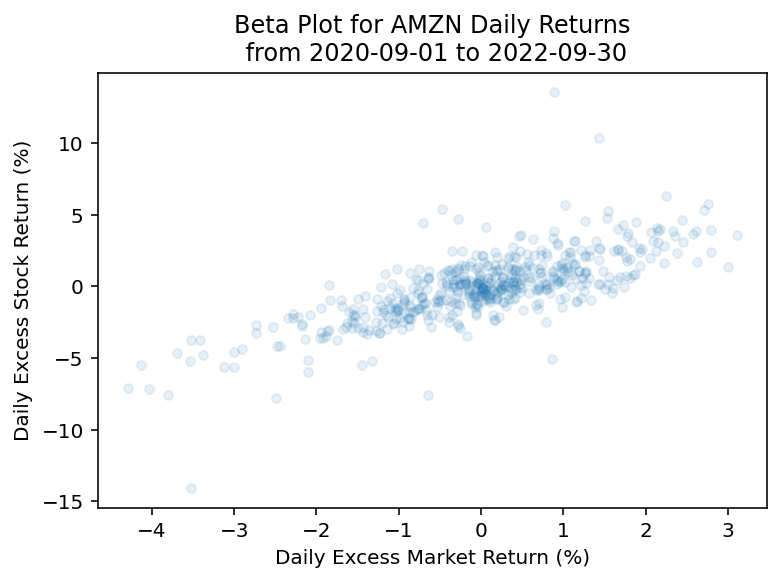

In [15]:
amzn.loc['2020-09':].plot(x='Rm', y='Ri', kind='scatter', alpha=0.1)
plt.ylabel('Daily Excess Stock Return (%)')
plt.xlabel('Daily Excess Market Return (%)')
first_date = amzn.loc['2020-09':, ['Ri', 'Rm']].dropna().index[0]
last_date = amzn.loc['2020-09':, ['Ri', 'Rm']].dropna().index[-1]
plt.title(f'Beta Plot for AMZN Daily Returns\n from {first_date:%Y-%m-%d} to {last_date:%Y-%m-%d}')
plt.show()

The easiest way to add the best-fit-line is to use `regplot()` from the seaborn package.

In [16]:
import seaborn as sns

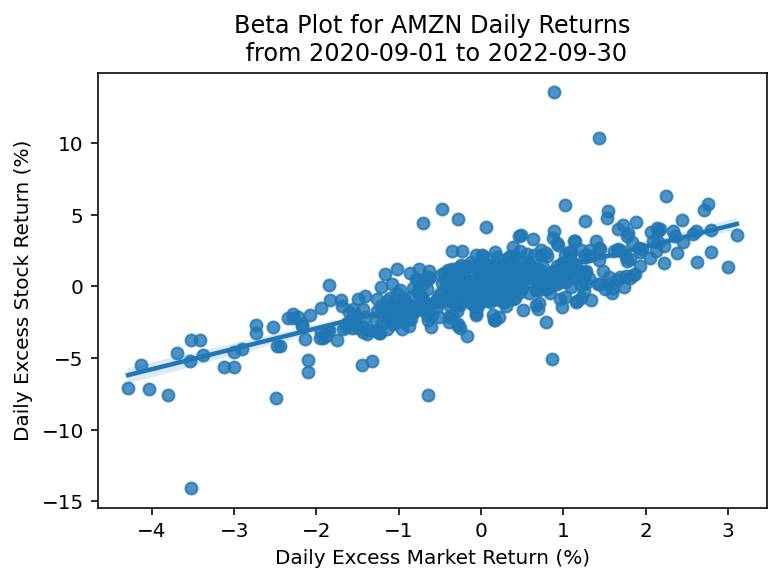

In [17]:
sns.regplot(x='Rm', y='Ri', data=amzn.loc['2020-09':])
plt.ylabel('Daily Excess Stock Return (%)')
plt.xlabel('Daily Excess Market Return (%)')
first_date = amzn.loc['2020-09':, ['Ri', 'Rm']].dropna().index[0]
last_date = amzn.loc['2020-09':, ['Ri', 'Rm']].dropna().index[-1]
plt.title(f'Beta Plot for AMZN Daily Returns\n from {first_date:%Y-%m-%d} to {last_date:%Y-%m-%d}')
plt.show()

We add the `Ri` and `Rm` columns to follow Lewinson's syntax.
However, the formula API provides two functions that help us avoid adding columns just for a regression:

1. `I()` lets us preform calculations on-the-fly inside a formula
1. `Q()` lets us use columns with bad names that contain spaces and other characters that would confuse our formula

In [18]:
smf.ols(formula='I(ri - rf) ~ Q("Mkt-RF")', data=amzn.loc['2020-09':]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             I(ri - rf)   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     655.8
Date:                Wed, 16 Nov 2022   Prob (F-statistic):           2.36e-94
Time:                        16:10:39   Log-Likelihood:                -980.34
No. Observations:                 525   AIC:                             1965.
Df Residuals:                     523   BIC:                             1973.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0704      0.068     -1.028      0.304      -0.205       0.064
Q("Mkt-RF")     1.4253      0.056     25.609      0.000       1.316       1.535
==============================================================================
Omnibus:                      163.635   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2869.374
Skew:                           0.875   Prob(JB):                         0.00
Kurtosis:                      14.319   Cond. No.                         1.23
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Implementing the Fama-French three-factor model in Python

Lewinson clearly summarizes the Fama and French three factor model:

> In their famous paper, Fama and French expanded the CAPM model by adding two additional factors explaining the excess returns of an asset or portfolio. The factors they considered are:
> 
> - The market factor (MKT): It measures the excess return of the market, analogical to the one in the CAPM.
> - The size factor, SMB (Small Minus Big): It measures the excess return of stocks with a small market cap over those with a large market cap.
> - The value factor, HML (High Minus Low): It measures the excess return of value stocks over growth stocks. Value stocks have a high book-to-market ratio, while the growth stocks are characterized by a low ratio.
> 
> The model can be represented as follows: $$E(r_i) = r_f + \alpha + \beta_{mkt} (E(r_m) - r_f) + \beta_{SMB} SMB + \beta_{HML} HML$$
> 
> Or in its simpler form: $$E(r_i) - r_f = \alpha + \beta_{mkt} (E(r_m) - r_f) + \beta_{SMB} SMB + \beta_{HML} HML$$
> 
> Here, $E(r_i)$ denotes the expected return on asset $i$, $r_f$ is the risk-free rate (such as a government bond), and $\alpha$ is the intercept. The reason for including the constant intercept is to make sure its value is equal to 0. This confirms that the three-factor model evaluates the relationship between the excess returns and the factors correctly.
> In the case of a statistically significant, non-zero intercept, the model might not evaluate the asset/portfolio return correctly. However, the authors stated that the three-factor model is "fairly correct", even when it is unable to pass the statistical test.
> 
> Due to the popularity of this approach, these factors became collectively known as the Fama-French Factors, or the Three-Factor Model. They have been widely accepted in both academia and the industry as stock market benchmarks and they are often used to evaluate investment performance.

Lewinson uses new data to implement the Fama and French three-factor model, but we can use the same Amazon data from above to save ourselves some time and memory.
As with CAPM estimations, we should estimate the three-factor model with one to three years of daily data.

There are two common uses for the three-factor model:

1. Use the coefficient estimate on the intercept (i.e., $\alpha$  often called "Jensen's $\alpha$") as a risk-adjusted performance measure. If $\alpha$ is positive and statistically significant, we may attribute a fund manager's performance to skill.
2. Use the remaining coefficient estimates to evaluate how the fund manager generates returns. If the regression $R^2$ is high, we may replace the fund manager with the factor itself.

We can estimate the Fama-French three-factor model for AMZN, again.

In [19]:
smf.ols(formula='Ri ~ Rm + SMB + HML', data=amzn.loc['2020-09':]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     Ri   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     315.5
Date:                Wed, 16 Nov 2022   Prob (F-statistic):          9.97e-117
Time:                        16:10:39   Log-Likelihood:                -921.82
No. Observations:                 525   AIC:                             1852.
Df Residuals:                     521   BIC:                             1869.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0190      0.062     -0.309      0.758      -0.140       0.102
Rm             1.3104      0.056     23.502      0.000       1.201       1.420
SMB           -0.4245      0.083     -5.128      0.000      -0.587      -0.262
HML           -0.5425      0.052    -10.370      0.000      -0.645      -0.440
==============================================================================
Omnibus:                      226.762   Durbin-Watson:                   2.063
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6125.967
Skew:                           1.285   Prob(JB):                         0.00
Kurtosis:                      19.536   Cond. No.                         2.05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Above, the coefficient on the market risk premium (`Rm`) is greater than one, indicating that AMZN has greater than average systematic risk.
The average stock has a market beta of one by construction.
The coefficient on SMB (i.e., small-minus-big) is significantly negative, indicating that AMZN has a negative exposure to the small-stock risk factor because AMZN is a big stock (i.e., has a big market capitalization).
Finally, the coefficient on HML is significantly negative, indicating that AMZN has a negative exposure to the value-stock risk factor because AMZN is a growth stock with high P/E (price/earnings) and low B/M (book-to-market equity ratio).

## Implementing the rolling three-factor model on a portfolio of assets

Lewinson manually estimates rolling three-factor regressions.
However, statsmodels estimates rolling regressions out of the box!

In [20]:
from statsmodels.regression.rolling import RollingOLS

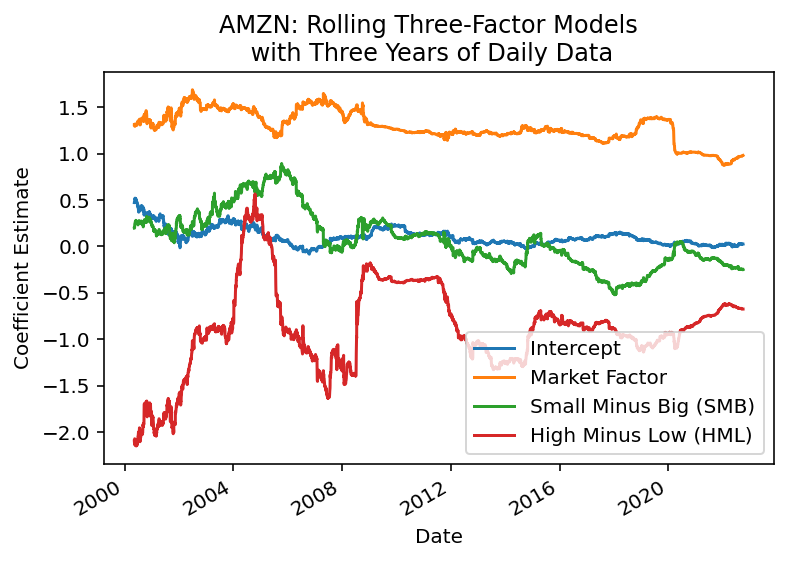

In [21]:
RollingOLS.from_formula('Ri ~ Rm + SMB + HML', data=amzn, window=3*252).fit().params.plot()
plt.legend(['Intercept', 'Market Factor', 'Small Minus Big (SMB)', 'High Minus Low (HML)'])
plt.ylabel('Coefficient Estimate')
plt.suptitle('AMZN: Rolling Three-Factor Models\n with Three Years of Daily Data')
plt.show()

## Implementing the four- and five-factor models in Python

There are literally hundreds of published factors!
However, many of them have little explanatory power (in or out of sample.
Two more factor models that have explanatory power and economic intuition are the four- and five-factor models.
The four-factor model is from Carhartt and the five-factor model is from Fama and French.

> In this recipe, we implement two extensions of the Fama-French three-factor model.
> 
> Carhart's Four-Factor model: The underlying assumption of this extension is that, within a short period of time, a winner stock will remain a winner, while a loser will remain a loser. An example of a criterion for classifying winners and losers could be the last 12-month cumulative total returns. After identifying the two groups, we long the winners and short the losers within a certain holding period.
> 
> The momentum factor (WML; Winners Minus Losers) measures the excess returns of the winner stocks over the loser stocks in the past 12 months (please refer to the See also section of this recipe for references on the calculations of the momentum factor).
> 
> The four-factor model can be expressed: $$E(r_i) - r_f = \alpha + \beta_{mkt}MKT + \beta_{smb}SMB + \beta_{HML}HML + \beta_{wml}WML$$
> 
> Fama-French's Five-Factor model: Fama and French expanded their three-factor model by adding two factors:
> 
> - Robust Minus Weak (RMW) measures the excess returns of companies with high profit margins (robust profitability) over those with lower profits (weak profitability).
> - Conservative Minus Aggressive (CMA) measures the excess returns of firms with low investment policies (conservative) over those investing more (aggressive).
> 
> The five-factor model can be expressed as follows: $$E(r_i) - r_f = \alpha + \beta_{mkt}MKT + \beta_{smb}SMB + \beta_{HML}HML + \beta_{rmw}RMW + \beta_{cma}CMA$$
> 
> Like in all factor models, if the exposure to the risk factors captures all possible variations in expected returns, the intercept (α) for all the assets/portfolios should be equal to zero.

We will explore the 4- and 5-factor models in the practice below.

## Practice

***Practice:***
Write a function `get_ff_data()` that accepts a list of tickers then:

1. Downloads Yahoo! Finance data for these tickers
1. Calculates returns for these tickers (returns in percent with the ticker as the column name)
1. Downloads data for the Fama-French 3-, 4-, and 5-factor models
1. Combines and returns these data (returns only returns and factors, where factors have their original names)

This function will make it easier to estimate the 3-, 4- and 5- factor models!

First we will write `get_ff_date()` to download data for one ticker and return the three factors (i.e., `Mkt-RF`, `SMB`, and '`HML`').

In [22]:
pdr.famafrench.get_available_datasets()[:5]

['F-F_Research_Data_Factors',
 'F-F_Research_Data_Factors_weekly',
 'F-F_Research_Data_Factors_daily',
 'F-F_Research_Data_5_Factors_2x3',
 'F-F_Research_Data_5_Factors_2x3_daily']

In [23]:
def get_ff_data(**kwargs):
    _stocks = yf.download(**kwargs)
    _stocks.index = _stocks.index.tz_localize(None)
    _ff = pdr.get_data_famafrench('F-F_Research_Data_5_Factors_2x3_daily', start='1900', session=session)[0]

    if isinstance(_stocks.columns, pd.MultiIndex):
        _returns = pd.concat(
            objs=[_stocks['Adj Close'].pct_change().mul(100)], # calculate returns
            keys=['Return'], # add index level
            names=['Variable', 'Ticker'], # with names
            axis=1 # to columns
        )

        _ff = pd.concat(
            objs=[_ff], # get Fama-French factors
            keys=['Return'], # add index level
            names=['Variable', 'Ticker'], # with names
            axis=1 # to columns
        )

        return _stocks.join([_returns, _ff])

    else:
        _stocks['Return'] = _stocks['Adj Close'].pct_change().mul(100)
        return _stocks.join(_ff)

We can use `get_ff_data()` and `smf.ols()` to quickly test is a manager has $\alpha$ (or edge or ability or returns not explained ny risk factors).
We can try with Berkshire Hathaway, which is Warren Buffett's conglomerate.
***My error in class was using ticker `BRK-B`, whose time series Yahoo! Finance recently truncated.***
***Instead, we will use `BRK-A`, which provides data back through 1980.***

In [24]:
brk_a = get_ff_data(tickers='BRK-A', session=session)

[*********************100%***********************]  1 of 1 completed

Buffett has an $\alpha$ of $0.0415\%$ per trading day, which annualizes to $252 \times 0.0415\% = 10.458\%$ for a 43-year period!

This $\alpha$ nearly doubles if we look earlier in the sample, from 1980 to 1990.
His $\alpha$ of $0.0775\%$ annualizes to $19.53\%$ of return not explained by market risk!

In [25]:
smf.ols(formula='I(Return - RF) ~ Q("Mkt-RF")', data=brk_a.loc[:'1990']).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         I(Return - RF)   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     403.5
Date:                Wed, 16 Nov 2022   Prob (F-statistic):           8.33e-84
Time:                        16:10:41   Log-Likelihood:                -4802.6
No. Observations:                2728   AIC:                             9609.
Df Residuals:                    2726   BIC:                             9621.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0775      0.027      2.874      0.004       0.025       0.130
Q("Mkt-RF")     0.5633      0.028     20.087      0.000       0.508       0.618
==============================================================================
Omnibus:                      394.590   Durbin-Watson:                   2.064
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5177.574
Skew:                           0.177   Prob(JB):                         0.00
Kurtosis:                       9.740   Cond. No.                         1.05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

***Side bar:*** What about GameStop (GME)?

In [26]:
gme = get_ff_data(tickers='GME', session=session)

[*********************100%***********************]  1 of 1 completed

In [27]:
smf.ols(formula='I(Return - RF) ~ Q("Mkt-RF") + SMB + HML', data=gme.loc['2020-12':]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         I(Return - RF)   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     15.83
Date:                Wed, 16 Nov 2022   Prob (F-statistic):           8.29e-10
Time:                        16:10:43   Log-Likelihood:                -1831.0
No. Observations:                 462   AIC:                             3670.
Df Residuals:                     458   BIC:                             3686.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.0693      0.597      1.792      0.074      -0.103       2.242
Q("Mkt-RF")     0.3770      0.556      0.678      0.498      -0.716       1.470
SMB             5.1777      0.805      6.428      0.000       3.595       6.761
HML            -0.0614      0.552     -0.111      0.911      -1.146       1.023
==============================================================================
Omnibus:                      467.150   Durbin-Watson:                   1.748
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            28340.167
Skew:                           4.294   Prob(JB):                         0.00
Kurtosis:                      40.396   Cond. No.                         2.05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- GME's intercept or $\alpha$ is positive (and almost statistically significant) because, despite its high volatility, the GME's price is much higher today than in December 2020
- GME's CAPM $\beta$ is small and not statistically different zero because GME does not have market risk (and is mostly detached from fundamentals)
- GME's SMB $\beta$ is large, positive, and statistically significant because GME is a small stock
- GME's HML $\beta$ is moderate, positive, and (practically) statistically significant because GME *was* a value stock (i.e., high book-to-market equity ratio) before its price run up

It may be help to look at GME's price over the last two years.

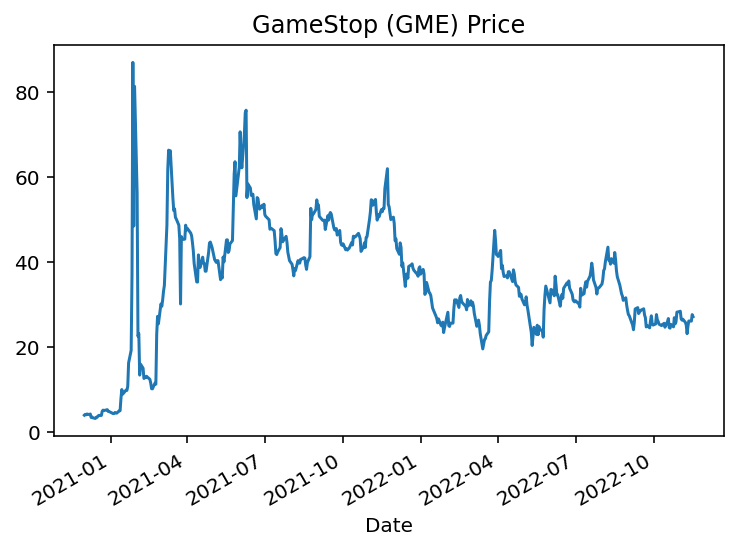

In [28]:
gme.loc['2020-12':, 'Adj Close'].plot()
plt.title('GameStop (GME) Price')
plt.show()

***FOR HOMEWORK: Modify `get_ff_data()` to handle 2+ tickers.***
***If you want to work ahead, further modify `get_ff_data()` to download the Fama-French momentum and five-factors.***

See above; we did this one in class.

***Practice:***
Estimate FF3 one-year rolling regressions for Warren Buffet's Berkshire-Hathaway holding company (ticker BRK-A).
What does the plot tell us about Warren Buffet's skill as an asset manager?

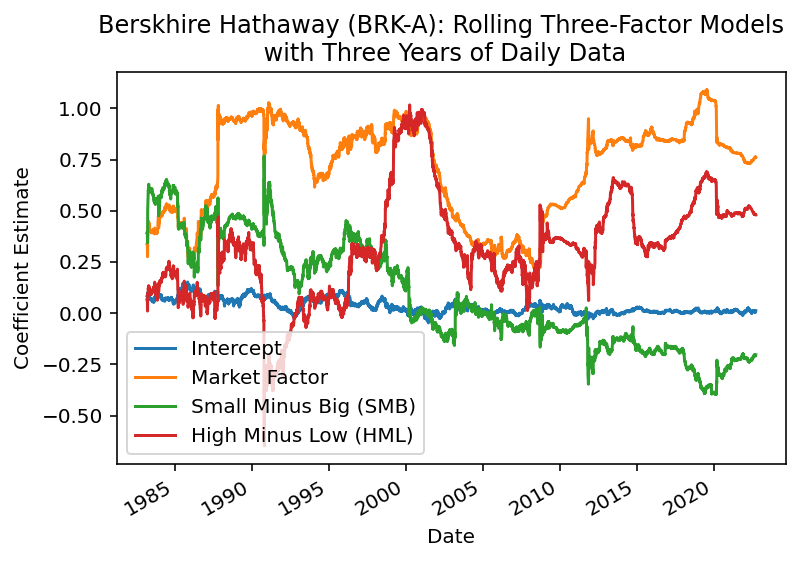

In [29]:
RollingOLS.from_formula(
    formula='I(Return - RF) ~ Q("Mkt-RF") + SMB + HML', 
    data=brk_a, 
    window=3*252
).fit().params.plot()
plt.legend(['Intercept', 'Market Factor', 'Small Minus Big (SMB)', 'High Minus Low (HML)'])
plt.ylabel('Coefficient Estimate')
plt.suptitle('Berskhire Hathaway (BRK-A): Rolling Three-Factor Models\n with Three Years of Daily Data')
plt.show()

***Practice:***
Write a function `get_ff_fit()` that uses the data from `get_ff_data()` and estimates a CAPM or multifactor model.
Use the following arguments:

1. `formula=` accepts a valid formula (e.g., `formula='I(TSLA-RF) ~ Q("Mkt-RF") + SMB + HML'`)
1. `data=` accepts the data from `get_ff_data()`
1. `start=` and `end=` are the beginning and ending dates for your analysis

In [30]:
def get_ff_fit(formula, data, start, end):
    _model = smf.ols(
        formula=formula,
        data=data.loc[start:end]
    )
    return _model.fit()

In [31]:
fit = get_ff_fit(
    formula='I(Return - RF) ~ Q("Mkt-RF") + SMB + HML',
    data=brk_a,
    start='1980',
    end='1990'
)
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         I(Return - RF)   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     153.9
Date:                Wed, 16 Nov 2022   Prob (F-statistic):           3.96e-92
Time:                        16:10:44   Log-Likelihood:                -4777.3
No. Observations:                2728   AIC:                             9563.
Df Residuals:                    2724   BIC:                             9586.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0711      0.027      2.652      0.008       0.019       0.124
Q("Mkt-RF")     0.7704      0.044     17.347      0.000       0.683       0.857
SMB             0.4105      0.058      7.033      0.000       0.296       0.525
HML             0.2805      0.087      3.233      0.001       0.110       0.451
==============================================================================
Omnibus:                      432.197   Durbin-Watson:                   2.082
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5323.053
Skew:                           0.336   Prob(JB):                         0.00
Kurtosis:                       9.810   Cond. No.                         3.79
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

***Practice:***
Write a function `plot_betas()` that use the fit object from `get_ff_fit()` to plot a bar chart with coefficient estimates and standard errors.

In [32]:
def plot_betas(fit, labels=None):
    _params = fit.params
    if labels is None:
        labels = _params.index
    _serrs = _params / fit.tvalues
    plt.bar(height=_params, x=labels, yerr=_serrs)
    return None

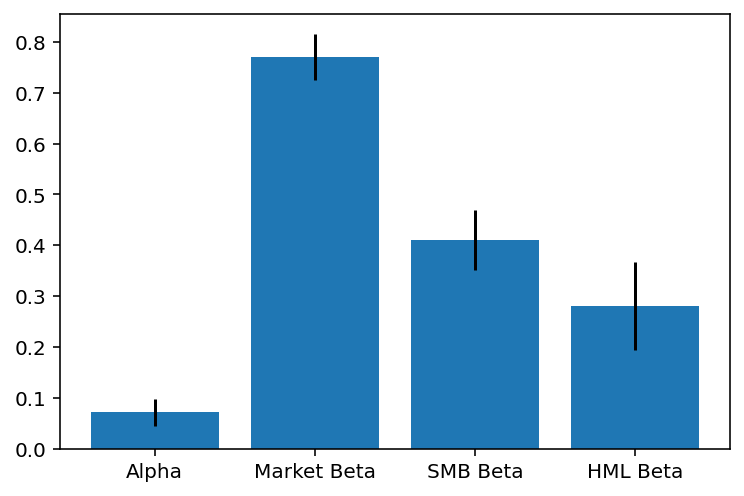

In [33]:
plot_betas(fit=fit, labels=['Alpha', 'Market Beta', 'SMB Beta', 'HML Beta'])

***Practice:***
Estimate FF5 one-year rolling regressions for BRK-A.
Do the additional factors explain Buffet's performance?

No, Buffett has alpha!
I will plot only the intercept/alpha to declutter the plot.

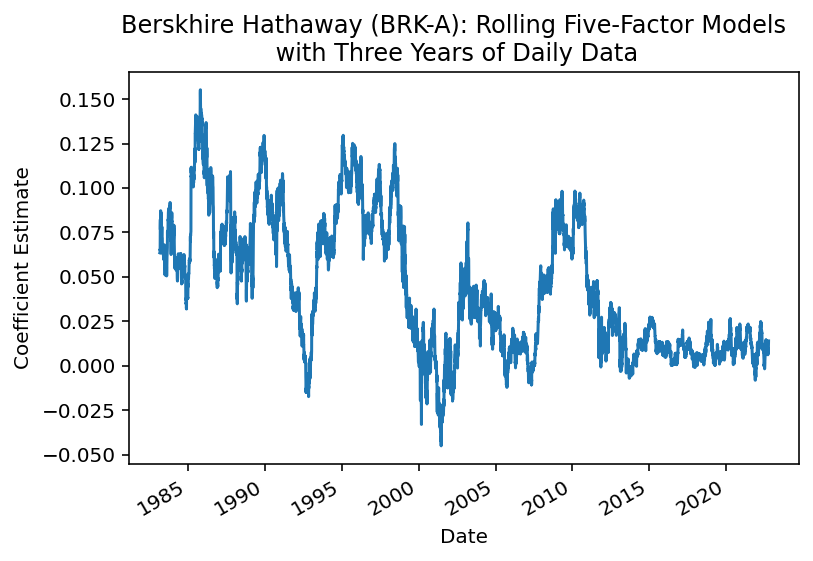

In [34]:
RollingOLS.from_formula(
    formula='I(Return - RF) ~ Q("Mkt-RF") + SMB + HML + RMW + CMA', 
    data=brk_a, 
    window=3*252
).fit().params['Intercept'].plot()
# plt.legend(['Intercept', 'Market Factor', 'Small Minus Big (SMB)', 'High Minus Low (HML)', 'Robust Minus Weak (RMW)', 'Conservative Minus Aggressive (CMA)'])
plt.ylabel('Coefficient Estimate')
plt.suptitle('Berskhire Hathaway (BRK-A): Rolling Five-Factor Models\n with Three Years of Daily Data')
plt.show()